In [1]:

!pip install conllu
!pip install pyconll
from conllu import parse
import torchtext.vocab

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pyconll
import torchtext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [2]:
train_path = "en_atis-ud-train.conllu"
test_path = "en_atis-ud-dev.conllu"
dev_path = "en_atis-ud-test.conllu"
unknown_token = "<unk>"

In [3]:

def extract_info_from_conllu(file_path):
    data = open(file_path, "r", encoding="utf-8").read()
    sentences = parse(data)

    extracted_info = []
    for sentence in sentences:
        for token in sentence:
            if token["form"].isalnum():
                extracted_info.append(
                    (token["id"], token["form"].lower(), token["upos"]))

    return extracted_info


def BuildVocabulary(file_path):
    extracted_info = extract_info_from_conllu(file_path)
    ids, Tokens, Tags = zip(*extracted_info)

    vocab_tokens = torchtext.vocab.build_vocab_from_iterator([Tokens])
    vocab_tokens.insert_token(unknown_token, 0)
    vocab_tokens.set_default_index(vocab_tokens[unknown_token])

    vocab_tags = torchtext.vocab.build_vocab_from_iterator([Tags])
    vocab_tags.insert_token(unknown_token, 0)
    vocab_tags.set_default_index(vocab_tags[unknown_token])

    vocab_ids = sorted(set(ids))
    return vocab_ids, vocab_tokens, vocab_tags

In [4]:

def load_and_tokenize_data(file_path, vocab_tokens, vocab_tags):
    corpus = pyconll.load_from_file(file_path)

    all_train_X = []
    all_train_Y = []

    for sentence in corpus:
        tokens = []
        tags = []
        for token in sentence:
            tokens.append(token.form.lower())
            tags.append(token.upos)

        train_X = get_tensored_tokens(tokens, vocab_tokens)
        train_Y = get_tensored_tokens(tags, vocab_tags)

        all_train_X.append(train_X)
        all_train_Y.append(train_Y)

    return all_train_X, all_train_Y


def get_tensored_tokens(tokens, vocab):
    token_indexes = []
    for token in tokens:
        if token in vocab:
            token_indexes.append(vocab[token])
        else:
            token_indexes.append(vocab[unknown_token])

    return token_indexes

In [5]:

class LSTM_Model(nn.Module):
    def __init__(self, vocab_len, pos_len, layers, emb_dim, hidd_dim,vocab_tokens,vocab_tags ):
        super().__init__()
        self.num_layers = layers
        self.vocab_tokens = vocab_tokens
        self.vocab_tags = vocab_tags
        self.vocab_dim = vocab_len
        self.pos_dim = pos_len
        self.embedding_dim = emb_dim
        self.hidden_dim = hidd_dim
        self.embedding = nn.Embedding(self.vocab_dim, self.embedding_dim)
        self.LSTM_Model = nn.LSTM(
            self.embedding_dim, self.hidden_dim, num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_dim, self.pos_dim)

    def forward(self, src, hidden):
        embedding = self.embedding(src)
        output, hidden = self.LSTM_Model(embedding, hidden)
        pred = torch.nn.functional.log_softmax(self.fc(output), dim=1)
        return pred

    def init_hidden(self, device):
        hidden = torch.zeros(self.num_layers, self.hidden_dim).to(device)
        return hidden, hidden

    # model.train_model(model, criterion, device, train_X, train_Y, optimizer)

    def train_model(self, model, criteria, device, train_x, train_y, optimizer=None, isTrian=True, make_report=False):
        total_loss = 0
        total_acc = 0
        model.train() if isTrian else model.eval()

        num_of_sent = len(train_x)

        if make_report:
            f = open("Report.txt", "a")

        for i in range(num_of_sent):
            model.zero_grad()
            hidden = model.init_hidden(device)

            x_np, y_np = np.array(train_x[i]), np.array(train_y[i])
            TrainX, TrainY = torch.tensor(x_np).to(device), torch.tensor(y_np).to(device)

            pred_y = model(TrainX, hidden)
            loss = criteria(pred_y, TrainY)
            total_loss += loss.item()

            if isTrian:
                loss.backward()
                optimizer.step()

            _, pred_ind = torch.max(pred_y, 1)

            token_size = len(TrainY)
            total_acc += sum(1 for i in range(token_size) if TrainY[i] == pred_ind[i]) / token_size

            if make_report:
                token_dict = self.vocab_tokens.get_stoi()
                tag_dict = self.vocab_tags.get_stoi()
                token_dictionary = {idx: token for token, idx in token_dict.items()}
                tag_dictionary = {idx: tag for tag, idx in tag_dict.items()}

                sentence_words = [token_dictionary[idx] for idx in train_x[i]]
                sentence = " ".join(sentence_words)
                f.write("Sentence: " + sentence + "\n")
                # Write the true tags to the report file
                true_labels = [tag_dictionary[idx] for idx in TrainY.cpu().numpy()]
                true_tags_text = " ".join(true_labels)
                f.write("True tags: " + true_tags_text + "\n")

                # Write the predicted tags to the report file
                pred_labels = [tag_dictionary[idx] for idx in pred_ind.cpu().numpy()]
                pred_tags_text = " ".join(pred_labels)
                f.write("Predicted tags: " + pred_tags_text + "\n")

                # Write the classification report to the report file
                true_labels = TrainY.cpu().numpy()
                pred_labels = pred_ind.cpu().numpy()
                report = classification_report(true_labels, pred_labels, zero_division=1)
                f.write("Classification Report:\n")
                f.write(report)
                f.write("\n")


        if make_report:
            f.write("Average Loss: {:.4f}\n".format(total_loss / num_of_sent))
            f.write("Average Accuracy: {:.2f} %\n".format((total_acc / num_of_sent) * 100.0))
            f.close()

        loss = total_loss / num_of_sent
        accuracy = (total_acc / num_of_sent) * 100.0

        return loss, accuracy


In [6]:
class FFNN_Model(nn.Module):
    def __init__(self, vocab_size, pos_size, embedding_dim, hidden_dim, p=2, s=3):
        super(FFNN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_size = pos_size
        self.vocab_size = vocab_size
        self.p = p
        self.s = s
        self.linr1 = (self.p + self.s + 1) * embedding_dim
        self.fc1 = nn.Linear(self.linr1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, self.pos_size)


    def forward(self, input):
        embedded = self.embedding(input)
        embedded = embedded.view(embedded.size(0), -1)
        x = torch.relu(self.fc1(embedded))
        last_out = self.fc2(x)
        pred = torch.nn.functional.log_softmax(last_out, dim=1)
        # print("Size of input tensor:", input.size())  # Print the size of input tensor
        # print("Size of embedded tensor after flattening:", embedded.size())
        # print("Size of tensor after fc1:", x.size())
        # print("Size of tensor after fc2:", last_out.size())
        # print("last_out", last_out)
        # print("pred", pred)
        return pred

    def get_pred(self, sentence_x):
        outputs = []
        for input_vector in sentence_x:
                input_tensor = input_vector.unsqueeze(0)
                output = self(input_tensor)
                # print(outputs,label)
                outputs.append(output)
        outputs = torch.cat(outputs, dim=0)
        _, pred_ind = torch.max(outputs, 1)
        return outputs, pred_ind

    def train_model(self, model, criterion, device, train_X, train_Y, optimizer, isTrain=True, make_report=False):
        self.to(device)
        self.train() if isTrain else self.eval()

        if make_report:
            f = open("Report.txt", "a")

        total_loss = 0.0
        total_correct = 0
        total_samples = len(train_X)

        for sentence_x, sentence_y in zip(train_X, train_Y):
            sentence_x = torch.tensor(sentence_x).to(device)
            sentence_y = torch.tensor(sentence_y).to(device)

            self.zero_grad()
            outputs = []
            labels = []

            outputs, pred_ind = self.get_pred(sentence_x)
            for label in sentence_y:
              labels.append(label)

            # for input_vector, label in zip(sentence_x, sentence_y):
            #     input_tensor = input_vector.unsqueeze(0)
            #     output = model(input_tensor)
            #     # print(outputs,label)
            #     outputs.append(output)
            #     labels.append(label)

            # outputs = torch.cat(outputs, dim=0)
            labels = torch.cat(labels, dim=0)

            # print("Size of outputs tensor:", outputs.size())
            # print("Size of labels tensor:", labels.size())
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            if isTrain:
                loss.backward()
                optimizer.step()

            # _, pred_ind = torch.max(outputs, 1)

            token_size = len(labels)
            total_correct += sum(1 for i in range(token_size) if labels[i] == pred_ind[i]) / token_size

        avg_loss = total_loss / total_samples
        accuracy = total_correct / total_samples * 100.0

        if make_report:
            f.write(f"Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%\n")
            f.close()

        return avg_loss, accuracy


In [7]:
def train_and_evaluate(model, optimizer, criterion, device, train_X, train_Y, dev_X, dev_Y, epochs,make_report = False):
    best_valid_loss = float('inf')
    best_valid_acc = float('inf')
    best_epoch_num = 0
    epoch_accuracies = []
    for epoch in range(epochs):
        train_loss, train_acc = model.train_model(
            model, criterion, device, train_X, train_Y, optimizer, True, make_report )
        valid_loss, valid_acc = model.train_model(
            model, criterion, device, dev_X, dev_Y,None, False, make_report )

        epoch_accuracies.append(valid_acc)

        if valid_loss < best_valid_loss:
            saved = True
            best_epoch_num = epoch
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            torch.save(model, 'ffnn_model_epoch.pt')

        print(f"Epoch- {epoch}")
        print(f"\tTrain Data Loss - {train_loss:.4f}, Accuracy - {train_acc:.2f} %")
        print(f"\tValidation Data Loss - {valid_loss:.4f}, Accuracy - {valid_acc:.2f} %")

    return best_valid_loss, best_epoch_num, best_valid_acc, epoch_accuracies


In [8]:
def print_pos_tags(sentence, pos_tags):
    for token, pos_tag in zip(sentence.split(), pos_tags):
        print(f"{token} {pos_tag}")


In [9]:
def train_rnn_model(train_path, dev_path,training=False, config = None, num_epochs=1,make_report = False):
    _, vocab_tokens, vocab_tags = BuildVocabulary(train_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if training:
      if config is None:
          # Set default configuration
          config = {
              'num_layers': 2,
              'emb_dim': 256,
              'hidden_dim': 512,
              'l_rate': 0.001
          }

      vocab_len, pos_len = len(vocab_tokens), len(vocab_tags)

      train_X, train_Y = load_and_tokenize_data(train_path, vocab_tokens, vocab_tags)
      dev_X, dev_Y = load_and_tokenize_data(dev_path, vocab_tokens, vocab_tags)

      num_layers = config.get('num_layers', 2)
      emb_dim = config.get('emb_dim', 256)
      hidden_dim = config.get('hidden_dim', 512)
      l_rate = config.get('l_rate', 0.001)
      epochs = num_epochs
      criteria = nn.NLLLoss()
      torch.manual_seed(0)

      model = LSTM_Model(vocab_len, pos_len, num_layers, emb_dim, hidden_dim,vocab_tokens, vocab_tags ).to(device)
      optimizer = optim.SGD(model.parameters(), lr=l_rate)

      print("|----------------------------|  Model |-----------------------|")
      print("Using device:", device)
      print("Number of layers:", num_layers)
      print("Embedding dimension:", emb_dim)
      print("Hidden dimension:", hidden_dim)
      print("Learning rate:", l_rate)
      print("Epochs:", epochs)
      print("Loss function:", criteria)
      print("Model architecture:")
      print(model)

      best_loss, best_epoch_num, best_acc, epoch_accuracies = train_and_evaluate(
          model, optimizer, criteria, device, train_X, train_Y, dev_X, dev_Y, epochs, make_report = make_report)

      print(" Best Loss : ", best_loss)
      print(" Best Accuracy : ", best_acc)
      print(" At epoch number : ", best_epoch_num)
    else :
      epoch_accuracies = []
      model = torch.load(
            "model_epoch.pt", map_location=torch.device('cpu')).to(device)

    return model, vocab_tokens, vocab_tags, epoch_accuracies

def output_pos_tags_rnn(model, sentence, vocab, vocab_tags):
    # Preprocess the sentence
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenized_sentence = sentence.lower().split()
    indexed_sentence = [vocab[token] if token in vocab else vocab[unknown_token]
                        for token in tokenized_sentence]
    # print(indexed_sentence)
    indexed_sentence_tensor = torch.tensor(indexed_sentence).to(device)

    hidden = model.init_hidden(indexed_sentence_tensor.device)
    with torch.no_grad():
        output = model(indexed_sentence_tensor, hidden)

    _, predicted_indices = torch.max(output, 1)
    predicted_tags = []

    tag_dict = vocab_tags.get_stoi()
    for idx in predicted_indices:
        pos_tag = [tag for tag, tag_idx in tag_dict.items()
                   if tag_idx == idx.item()]
        if pos_tag:
            predicted_tags.append(pos_tag[0])
        else:
            predicted_tags.append("UNKNOWN_TAG")

    print_pos_tags(sentence, predicted_tags)

In [34]:
def ffn_load_and_tokenize_data(file_path, vocab_tokens, vocab_tags, p, s):
    corpus = pyconll.load_from_file(file_path)
    # print(p,s,"testing")
    all_train_X = []
    all_train_Y = []

    for sentence in corpus:
        tokens = []
        tags = []
        for token in sentence:
            tokens.append(token.form.lower())
            tags.append(token.upos)

        tokens = [unknown_token] * p + tokens
        tokens += [unknown_token] * s

        sentence_X = []
        tags_x = []
        for i in range(p, len(tokens) - s):
            current_token = tokens[i]
            previous_tokens = tokens[max(0, i - p ):i]
            successive_tokens = tokens[i + 1:i + 1 + s]

            current_tag = tags[i - p]
            tag = get_tensored_tokens([current_tag], vocab_tags)
            current_X = get_tensored_tokens([current_token], vocab_tokens)
            previous_X = get_tensored_tokens(previous_tokens, vocab_tokens)
            successive_X = get_tensored_tokens(successive_tokens, vocab_tokens)

            # Concatenate previous, current, and successive tokens
            concatenated_X = previous_X + current_X + successive_X

            sentence_X.append(concatenated_X)
            tags_x.append(tag)
        all_train_X.append(sentence_X)
        all_train_Y.append(tags_x)

    return all_train_X, all_train_Y



def train_ffn_model(train_path, dev_path, training=False, config=None, num_epochs=1, make_report=False):
    _, vocab_tokens, vocab_tags = BuildVocabulary(train_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if training:
        if config is None:
            config = {
                'p': 2,
                's': 3,
                'emb_dim': 256,
                'hidden_dim': 512,
                'l_rate': 0.001
            }

        vocab_len, pos_len = len(vocab_tokens), len(vocab_tags)
        p = config.get('p', 2)
        s = config.get('s', 3)
        train_X, train_Y = ffn_load_and_tokenize_data(
            train_path, vocab_tokens, vocab_tags,p,s)
        dev_X, dev_Y = ffn_load_and_tokenize_data(
            dev_path, vocab_tokens, vocab_tags,p,s)

        train_X1, train_Y2 = load_and_tokenize_data(
            train_path, vocab_tokens, vocab_tags)

        # print("First 15 entries of train_X1 and train_Y2:")
        # for i in range(15):
        #     current = train_X[i]
        #     labels = train_Y[i]

        #     current1 = train_X1[i]
        #     labels2 = train_Y2[i]

        #     print(f"Entry {i + 1}:")
        #     print("Size of train_X:", len(current))
        #     print("Size of train_Y:", len(labels))
        #     print("Size of train_X1:", len(current1))
        #     print("Size of train_Y2:", len(labels2))
        #     print("train_X - Current:", current)
        #     print("train_Y:", labels)
        #     print("train_X1:", current1)
        #     print("train_Y2:", labels2)
        #     print()

        emb_dim = config.get('emb_dim', 256)
        hidden_dim = config.get('hidden_dim', 512)
        l_rate = config.get('l_rate', 0.001)
        epochs = num_epochs
        criteria = nn.NLLLoss()
        torch.manual_seed(0)
        # def __init__(self, vocab_size,pos_size,embedding_dim, hidden_dim, p = 2,s = 3 ):
        model = FFNN_Model(vocab_len, pos_len, emb_dim, hidden_dim, p, s).to(device)
        optimizer = optim.SGD(model.parameters(), lr=l_rate)

        print("|----------------------------|  FFN Model |-----------------------|")
        print("Using device:", device)
        print("p:", p)
        print("s:", s)
        print("Embedding dimension:", emb_dim)
        print("Hidden dimension:", hidden_dim)
        print("Learning rate:", l_rate)
        print("Epochs:", epochs)
        print("Loss function:", criteria)
        print("Model architecture:")
        print(model)
        print(model.linr1)
        best_loss, best_epoch_num, best_acc, epoch_accuracies = train_and_evaluate(
            model, optimizer, criteria, device, train_X, train_Y, dev_X, dev_Y, epochs, make_report=make_report)

        print(" Best Loss : ", best_loss)
        print(" Best Accuracy : ", best_acc)
        print(" At epoch number : ", best_epoch_num)
    else:
        epoch_accuracies=[]
        model = torch.load(
            "ffnn_model_epoch.pt", map_location=torch.device('cpu')).to(device)

    return model, vocab_tokens, vocab_tags, epoch_accuracies
# output_pos_tags_ffn(model, sentence, vocab_tokens, vocab_tags)
def output_pos_tags_ffn(model, sentence, vocab, vocab_tags):
    p = model.p
    s = model.s
    # print(p,s)
    # print(model)
    # Preprocess the sentence
    tokenized_sentence = sentence.lower().split()
    # print(indexed_sentence)
    tokenized_sentence = [unknown_token] * p + tokenized_sentence
    tokenized_sentence += [unknown_token] * s
    # print(tokenized_sentence)
    # indexed_sentence = [vocab[token] if token in vocab else vocab[unknown_token]
    #                     for token in tokenized_sentence]
    # print(indexed_sentence)
    indexed_sentence = tokenized_sentence
    sentence_X = []
    for i in range(p, len(indexed_sentence) - s):
        current_token = indexed_sentence[i]
        previous_tokens = indexed_sentence[max(0, i - p ):i]
        successive_tokens = indexed_sentence[i + 1:i + 1 + s]

        current_X = get_tensored_tokens([current_token], vocab_tokens)
        previous_X = get_tensored_tokens(previous_tokens, vocab_tokens)
        successive_X = get_tensored_tokens(successive_tokens, vocab_tokens)

        # Concatenate previous, current, and successive tokens
        concatenated_X = previous_X + current_X + successive_X
        sentence_X.append(concatenated_X)
    # print(sentence_X)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    indexed_sentence_tensor = torch.tensor(sentence_X).to(device)

    with torch.no_grad():
        output = model(indexed_sentence_tensor)

    _, predicted_indices = torch.max(output, 1)
    predicted_tags = []

    tag_dict = vocab_tags.get_stoi()
    for idx in predicted_indices:
        pos_tag = [tag for tag, tag_idx in tag_dict.items()
                   if tag_idx == idx.item()]
        if pos_tag:
            predicted_tags.append(pos_tag[0])
        else:
            predicted_tags.append("UNKNOWN_TAG")

    print_pos_tags(sentence, predicted_tags)



In [26]:
def run_experiments(configs, train_path, dev_path, test_path, num_epochs=10,isFFN = False):
    dev_results = []
    _, vocab_tokens, vocab_tags = BuildVocabulary(train_path)
    if not isFFN:
        test_X, test_Y = load_and_tokenize_data(
                test_path, vocab_tokens, vocab_tags)
        dev_X, dev_Y = load_and_tokenize_data(
                dev_path, vocab_tokens, vocab_tags)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criteria = nn.NLLLoss()
    models = []
    evaluation_reports = []

    for config in configs:
        # Train model with current configuration
        if not isFFN:
          model, _, _, epoch_accuracies = train_rnn_model(train_path, dev_path, training=True, config=config, num_epochs=num_epochs, make_report = False)
        else:
          model, _, _, epoch_accuracies = train_ffn_model(train_path, dev_path, training=True, config=config, num_epochs=num_epochs, make_report = False)
        models.append(model)
        # Append epoch accuracies to dev_results
        dev_results.append({'config': config, 'epoch_accuracies': epoch_accuracies})

    # Select best configuration based on dev set accuracy
    best_config = max(dev_results, key=lambda x: max(x['epoch_accuracies']))
    best_model = models[dev_results.index(best_config)]

    for model, config in zip(models, configs):
        if  isFFN:
          p = config.get('p', 2)
          s = config.get('s', 3)
          test_X, test_Y = ffn_load_and_tokenize_data(
                  test_path, vocab_tokens, vocab_tags,p,s)
          dev_X, dev_Y = ffn_load_and_tokenize_data(
                  dev_path, vocab_tokens, vocab_tags,p,s)
          model.p = p
          model.s = s
          print(model,config)
       # Evaluate model on dev set and test set
        dev_loss, dev_accuracy = model.train_model(model, criteria, device, dev_X, dev_Y,None, False,True)
        test_loss, test_accuracy = model.train_model(model, criteria, device, test_X, test_Y,None, False, False)

        # Generate evaluation report
        evaluation_report = {
            'config': config,
            'dev_loss': dev_loss,
            'dev_accuracy': dev_accuracy,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy
        }
        evaluation_reports.append(evaluation_report)

    if  isFFN:
          p = best_config['config']['p']
          s = best_config['config']['s']
          test_X, test_Y = ffn_load_and_tokenize_data(
                  test_path, vocab_tokens, vocab_tags,p,s)
          best_model.p = p
          best_model.s = s
          print(p,s)
    print(best_model , best_config)
    # Evaluate best configuration on test set
    test_loss, test_accuracy = best_model.train_model(
            best_model, criteria, device, test_X, test_Y,None, False,False)

    # Plot epoch vs. dev set accuracy for all configurations
    plot_accuracy_vs_epoch(dev_results)
    write_evaluation_report(evaluation_reports, best_config, train_path, dev_path, test_path)

    return best_model, best_config['config'], test_loss, test_accuracy


def write_evaluation_report(evaluation_reports, best_config, train_path, dev_path, test_path):
    with open("evaluation_report.txt", "w") as f:
        f.write("Hyperparameters used:\n")
        f.write("Best Configuration:\n")
        f.write(str(best_config) + "\n\n")

        f.write("Evaluation Metrics:\n")
        for report in evaluation_reports:
            f.write("Configuration: {}\n".format(report['config']))
            f.write("Dev Set Loss: {}\n".format(report['dev_loss']))
            f.write("Dev Set Accuracy: {}\n".format(report['dev_accuracy']))
            f.write("Test Set Loss: {}\n".format(report['test_loss']))
            f.write("Test Set Accuracy: {}\n\n".format(report['test_accuracy']))

def plot_accuracy_vs_epoch(dev_results):
    plt.figure(figsize=(10, 6))
    for result in dev_results:
        config = result['config']
        epoch_accuracies = result['epoch_accuracies']
        epochs = range(1, len(epoch_accuracies) + 1)
        plt.plot(epochs, epoch_accuracies, label=f'Config: {config}')

    plt.xlabel('Epoch')
    plt.ylabel('Dev Set Accuracy')
    plt.title('Epoch vs. Dev Set Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:

configs = [
    {'num_layers': 1, 'emb_dim': 128, 'hidden_dim': 256, 'l_rate': 0.001}
    ,{'num_layers': 2, 'emb_dim': 256, 'hidden_dim': 512, 'l_rate': 0.001}
    ,{'num_layers': 3, 'emb_dim': 512, 'hidden_dim': 1024, 'l_rate': 0.001}
]

best_model, best_config, test_loss, test_accuracy = run_experiments(configs, train_path, dev_path, test_path, num_epochs=50)

# Print the results
print("Best Model:", best_model)
print("Best Configuration:", best_config)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

|----------------------------|  Model |-----------------------|
Using device: cuda
Number of layers: 1
Embedding dimension: 128
Hidden dimension: 256
Learning rate: 0.001
Epochs: 50
Loss function: NLLLoss()
Model architecture:
LSTM_Model(
  (vocab_tokens): Vocab()
  (vocab_tags): Vocab()
  (embedding): Embedding(854, 128)
  (LSTM_Model): LSTM(128, 256)
  (fc): Linear(in_features=256, out_features=14, bias=True)
)
Epoch- 0
	Train Data Loss - 2.2097, Accuracy - 40.13 %
	Validation Data Loss - 1.8471, Accuracy - 48.10 %
Epoch- 1
	Train Data Loss - 1.6087, Accuracy - 55.25 %
	Validation Data Loss - 1.4451, Accuracy - 61.93 %
Epoch- 2
	Train Data Loss - 1.2916, Accuracy - 66.92 %
	Validation Data Loss - 1.1995, Accuracy - 68.82 %
Epoch- 3
	Train Data Loss - 1.0849, Accuracy - 72.10 %
	Validation Data Loss - 1.0303, Accuracy - 73.30 %
Epoch- 4
	Train Data Loss - 0.9404, Accuracy - 75.40 %
	Validation Data Loss - 0.9059, Accuracy - 76.29 %
Epoch- 5
	Train Data Loss - 0.8322, Accuracy - 77.93 

|----------------------------|  FFN Model |-----------------------|
Using device: cuda
p: 3
s: 4
Embedding dimension: 128
Hidden dimension: 256
Learning rate: 0.001
Epochs: 16
Loss function: NLLLoss()
Model architecture:
FFNN_Model(
  (embedding): Embedding(854, 128)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=14, bias=True)
)
1024
Epoch- 0
	Train Data Loss - 1.0993, Accuracy - 71.01 %
	Validation Data Loss - 0.7128, Accuracy - 79.49 %
Epoch- 1
	Train Data Loss - 0.5211, Accuracy - 86.02 %
	Validation Data Loss - 0.4629, Accuracy - 87.10 %
Epoch- 2
	Train Data Loss - 0.3566, Accuracy - 91.05 %
	Validation Data Loss - 0.3528, Accuracy - 90.12 %
Epoch- 3
	Train Data Loss - 0.2767, Accuracy - 93.03 %
	Validation Data Loss - 0.2937, Accuracy - 92.02 %
Epoch- 4
	Train Data Loss - 0.2302, Accuracy - 94.15 %
	Validation Data Loss - 0.2581, Accuracy - 92.92 %
Epoch- 5
	Train Data Loss - 0.1996, Accuracy - 94.87 %
	Validation Data

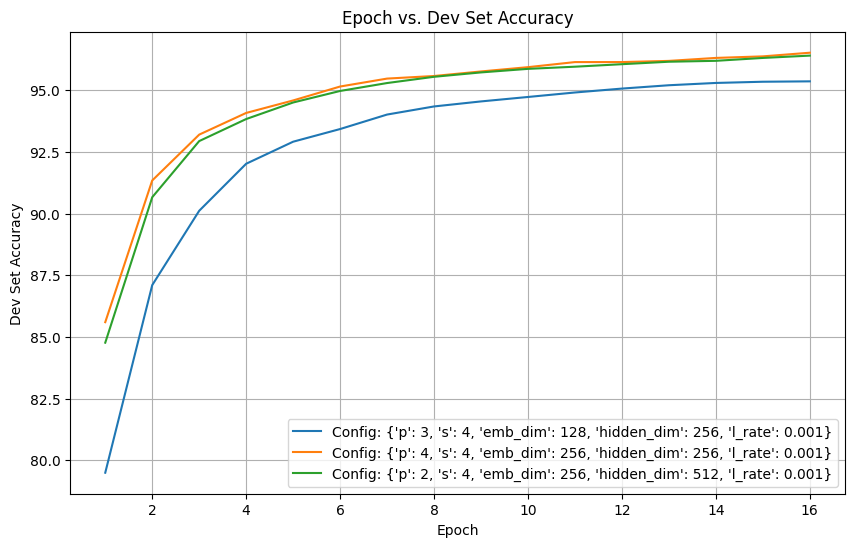

Best Model: FFNN_Model(
  (embedding): Embedding(854, 256)
  (fc1): Linear(in_features=2304, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=14, bias=True)
)
Best Configuration: {'p': 4, 's': 4, 'emb_dim': 256, 'hidden_dim': 256, 'l_rate': 0.001}
Test Loss: 0.129026093322056
Test Accuracy: 95.81376052935974


In [29]:

configs = [{'p': 3, 's': 4, 'emb_dim': 128, 'hidden_dim': 256, 'l_rate': 0.001},
           {'p': 4, 's': 4, 'emb_dim': 256, 'hidden_dim': 256, 'l_rate': 0.001}
           ,{'p': 2, 's': 4, 'emb_dim': 256, 'hidden_dim': 512, 'l_rate': 0.001}
           ]

best_model, best_config, test_loss, test_accuracy = run_experiments(configs, train_path, dev_path, test_path, num_epochs = 16,isFFN = True)

print("Best Model:", best_model)
print("Best Configuration:", best_config)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [30]:
config = {
    'p': 4,
    's': 4,
    'emb_dim': 256,
    'hidden_dim': 256,
    'l_rate': 0.001
}

model, vocab_tokens, vocab_tags, epoch_accuracies = train_ffn_model(train_path, dev_path, training=True, config=config, num_epochs=16, make_report=False)


|----------------------------|  FFN Model |-----------------------|
Using device: cuda
p: 4
s: 4
Embedding dimension: 256
Hidden dimension: 256
Learning rate: 0.001
Epochs: 16
Loss function: NLLLoss()
Model architecture:
FFNN_Model(
  (embedding): Embedding(854, 256)
  (fc1): Linear(in_features=2304, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=14, bias=True)
)
2304
Epoch- 0
	Train Data Loss - 0.8994, Accuracy - 75.83 %
	Validation Data Loss - 0.5463, Accuracy - 85.60 %
Epoch- 1
	Train Data Loss - 0.3619, Accuracy - 91.28 %
	Validation Data Loss - 0.3310, Accuracy - 91.35 %
Epoch- 2
	Train Data Loss - 0.2368, Accuracy - 94.26 %
	Validation Data Loss - 0.2509, Accuracy - 93.21 %
Epoch- 3
	Train Data Loss - 0.1817, Accuracy - 95.52 %
	Validation Data Loss - 0.2107, Accuracy - 94.08 %
Epoch- 4
	Train Data Loss - 0.1494, Accuracy - 96.29 %
	Validation Data Loss - 0.1868, Accuracy - 94.59 %
Epoch- 5
	Train Data Loss - 0.1274, Accuracy - 96.80 %
	Validation Data

In [ ]:
# print("Trained Model:")
# print(model)

# print("Vocabulary Tokens:")
# print(vocab_tokens)

# print("Vocabulary Tags:")
# print(vocab_tags)

In [35]:
training = False
m_type = 'f'

if m_type == 'r':
    model, vocab_tokens, vocab_tags,_ = train_rnn_model(train_path, dev_path,training)

    sentence = input("Enter a sentence : ")
    output_pos_tags_rnn(model, sentence, vocab_tokens, vocab_tags)

elif m_type == 'f':
    model, vocab_tokens, vocab_tags,_ = train_ffn_model(train_path, dev_path,training)

    # sentence = input("Enter a sentence :")
    sentence = "An apple a day"
    output_pos_tags_ffn(model, sentence, vocab_tokens, vocab_tags)
else:
    print("Please provide either 'r' or 'f' option to specify the POS tagger to use.")


An NOUN
apple ADV
a DET
day NOUN
